# Tutorial: Unbranched GRN velocity along oligodendrocytes differentiation

Raw data used in this tutorial is available in GEO (GSE210749).

Processed loom files are available at: https://scope.aertslab.org/#/scenic-v2

A UCSC session is available at: https://genome-euro.ucsc.edu/s/cbravo/SCENIC%2B_Cortex

## 1. Preprocessing: Find your trajectories

### 1a. Create your eGRN annData object

In this tutorial we are working with an unbranched trajectory, so we only have one trajectory. We will start by creating an anndata object with the GRN AUC values:

In [2]:
# Reset random seed
import numpy as np
np.random.seed(5)
# Set out directory
outDir='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/GRN_velocity/'

In [3]:
# Load data
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/'
import dill
infile = open(outDir+'scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [24]:
# Create anndata from AUC matrix (use both gene and region-based cistromes)
import pandas as pd
import anndata
auc_key = 'eRegulon_AUC'
signature_keys = ['Gene_based', 'Region_based']
data_mat = pd.concat([scplus_obj.uns[auc_key][x].T for x in signature_keys])
selected_regulons = [x for x in data_mat.index if '+_+' in x or '-_+' in x]
data_mat = data_mat.loc[selected_regulons]
adata = anndata.AnnData(X=data_mat.T.copy())
adata.obs = scplus_obj.metadata_cell.copy()

/local_scratch/tmp-vsc31305/ipykernel_76356/3001293104.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=data_mat.T.copy())


We will now subset the cells involved in the trajectory. In this case we also combined 5 runs from 5 different sample preparation protocols, and we noticed that for 2 of the protocols the quality of the oligodendrocytes was lower. Hence, we will also keep only oligodendrocytes from the best protocols:

In [25]:
# Keep only cell types involved in the differentiation trajectory
adata = adata[adata.obs['GEX_consensus_cell_type'].isin(['OPC', 'OL'])]
adata = adata[adata.obs['GEX_sample_id'].isin(['TST_NP40_004', 'TST', '10x_complex_UC'])]

We can also select the most variable regulons within these cell types:

In [26]:
# Select variable eGRNs
import scanpy as sc
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

/opt/venv/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


We can quickly process the data to generate embeddings and cluster:

In [27]:
# Make PCA
sc.tl.pca(adata)
# Harmony to correct batch
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'GEX_sample_id')
# Neighbours and clustering
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.leiden(adata, resolution=1)
# Diffusion map
sc.tl.diffmap(adata, random_state=5)

2022-08-10 16:17:34,759 - harmonypy - INFO - Iteration 1 of 10
2022-08-10 16:17:35,511 - harmonypy - INFO - Iteration 2 of 10
2022-08-10 16:17:36,265 - harmonypy - INFO - Iteration 3 of 10
2022-08-10 16:17:37,021 - harmonypy - INFO - Iteration 4 of 10
2022-08-10 16:17:37,796 - harmonypy - INFO - Iteration 5 of 10
2022-08-10 16:17:38,578 - harmonypy - INFO - Iteration 6 of 10
2022-08-10 16:17:39,356 - harmonypy - INFO - Iteration 7 of 10
2022-08-10 16:17:40,137 - harmonypy - INFO - Iteration 8 of 10
2022-08-10 16:17:40,917 - harmonypy - INFO - Iteration 9 of 10
2022-08-10 16:17:41,696 - harmonypy - INFO - Iteration 10 of 10
2022-08-10 16:17:42,308 - harmonypy - INFO - Converged after 10 iterations


We will also add the TF expression to the anndata object. This can be useful for plotting:

In [30]:
import pandas as pd
import anndata
import sklearn
adata_gene = anndata.AnnData(X=scplus_obj.to_df('EXP').copy())
sc.pp.normalize_total(adata_gene, target_sum=1e4)
sc.pp.log1p(adata_gene)
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
adata_all = ad.concat([adata, adata_gene], axis=1, merge='unique', uns_merge='unique').copy()
adata = adata_all

Let's save this object:

In [32]:
# Save
adata.obs.drop('ACC_Predicted_doublets_fragments', axis=1, inplace=True)
adata.write_h5ad(outDir+'OL_anndata.h5ad')

### 1b. Create or add embedding

To plot our GRN velocity arrows we can:
    
* Generate a new embedding based on the GRN AUC values (as we will do in the eye disc tutorial)
* Use a prexisting embedding
    
In this case we will use the coordinates from the SCENIC+ UMAP in the whole mouse cortex, subsetting oligodendrocyte cells only.

In [33]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'OL_anndata.h5ad')

In [34]:
# Add UMAP coordinates
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
path_to_loom = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/data/MO_GEX_seurat_Cortex.loom'
loom = SCopeLoom.read_loom(path_to_loom)

In [35]:
# Fix names to match with those in anndata
cell_data = get_metadata(loom)
cell_data = cell_data.replace('TEW__c14e1d__Multiome_RNA_brain_10x_no_perm', '10x_no_perm')
cell_data = cell_data.replace('TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004', 'TST_NP40_004')
cell_data = cell_data.replace('TEW__75da5c__5b0f59__Multiome_brain_TST', 'TST')
cell_data = cell_data.replace('TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC', '10x_complex_UC')
cell_data = cell_data.replace('TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex', '10x_complex')
cell_data['barcode'] = [x.split('___')[0] for x in cell_data.index.tolist()]
cell_data.index = cell_data['barcode'] + '___' + cell_data['sample_id']

In [36]:
# Format selected embedding
embeddings = {key: loom.embeddings[key].get_embedding() for key in loom.embeddings.keys()}
embeddings['Seurat Harmony UMAP'].index = cell_data.index
adata.obsm['X_umap'] = embeddings['Seurat Harmony UMAP'].loc[adata.obs.index]
embedding = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['x', 'y'])
embedding.iloc[:,0] = embedding.iloc[:,0]+abs(min(embedding.iloc[:,0]))
embedding.iloc[:,1] = embedding.iloc[:,1]+abs(min(embedding.iloc[:,1]))
adata.obsm['X_umap'].columns = ['x', 'y']

In [37]:
# Save
adata.write_h5ad(outDir+'OL_anndata.h5ad')

### 1c. Refine annotations (optional)

We can refine annotations in the trajectory based on the GRN-based clustering:

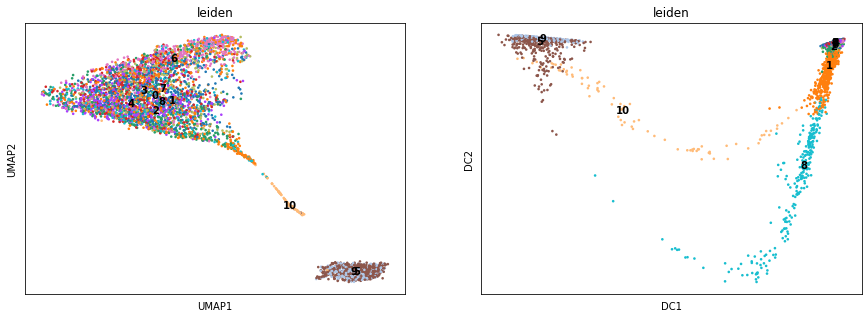

In [38]:
# Rename the division point as SMW.
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
ax1_dict = sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.diffmap(adata, color='leiden', legend_loc='on data', ax=ax2, show=False)

Let's annotate the intermediate oligodendrocytes:

In [39]:
# Rename cluster 10
sc.tl.leiden(adata, resolution=1)
adata.obs['Diff_state'] = adata.obs['GEX_consensus_cell_type'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state'] = 'NFOL'

We can also use PAGA to confirm the most likely differentiation path. For unbranched trajectories this is optional, but we recommend to use it with branched trejectories to identify the bifurcation point:

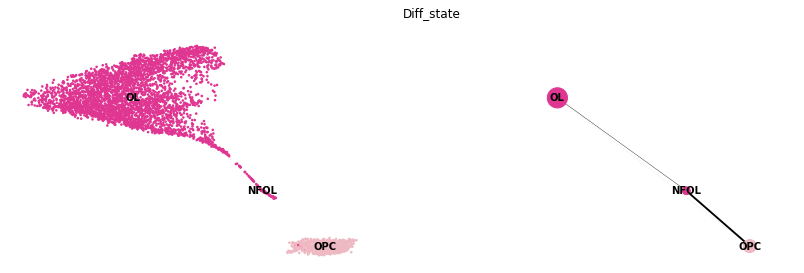

In [40]:
# PAGA graph
sc.tl.paga(adata, groups='Diff_state')
sc.pl.paga_compare(adata, basis='umap', threshold=0, palette={
        "OPC": "#eeb9c2",
        "NFOL": "#df3692",
        "OL": "#df3692",
    }, save='paga_plot.pdf')

In [41]:
# Save
adata.write_h5ad(outDir+'OL_anndata.h5ad')

### 1d. Add embedding-based pseudotime

To be able to identify the differentiation arrows, we need to get a pseudotime that represents the differentiation order. We can use the `get_embedding_dpt` function for this: 

In [1]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'OL_anndata.h5ad')

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


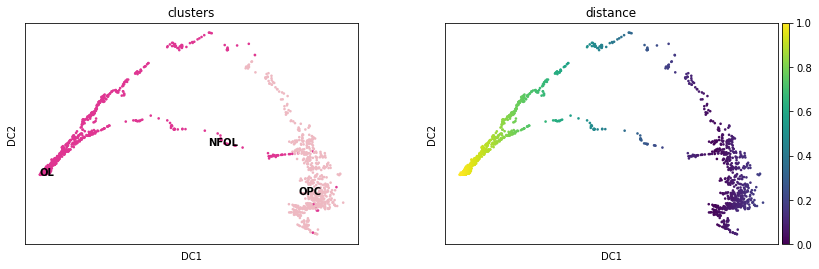

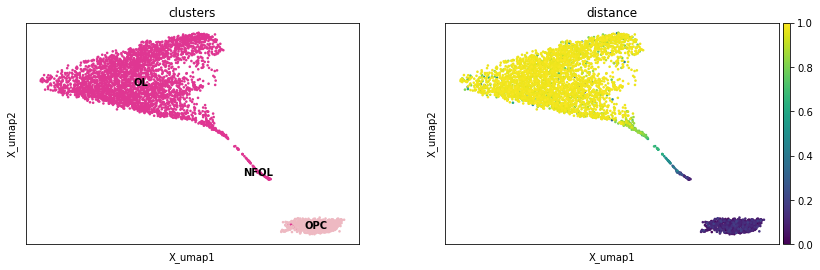

In [43]:
# Choose the embedding you want to plot arrows in. Here I will use the refined annotation because it separates better the branches in the diffusion map.
# The function will already save the annotations as clusters and distance, which are require for downstream steps.
from scenicplus.differentiation_potential import *
get_embedding_dpt(adata, 'Diff_state', 'OPC', embedding_key='X_diffmap', n_dcs=2, figsize=(12,8), palette={
        "OPC": "#eeb9c2",
        "NFOL": "#df3692",
        "OL": "#df3692",
    })

In [44]:
# Save
adata.write_h5ad(outDir+'OL_anndata.h5ad')

## 2. Inferring differentiation arrows

Next, we need to identify the changes in TF expression, target regions accessibility and target gene expression along the different paths using the `get_path_matrix` function. For this we have to specify the paths and the cell types involved, in this case it goes from OPC, to NFOL and finally OL:

In [51]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'OL_anndata.h5ad')

In [52]:
# Set paths
paths = [('OL', ['OPC', 'NFOL', 'OL'])]

In [53]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
from scenicplus.differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

Before plotting the differentiation arrows, we can check how TF expression, target regions accessibility and target gene expression change along the differentiation branches. By default, we fit a standarized GAM model for each of the measurements:

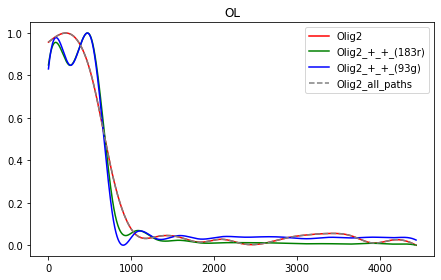

In [55]:
# Plot changes along trajectory
os.mkdir(outDir+'/curve_plots/')
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Olig2_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig(outDir+'/curve_plots/Olig2.pdf')

With the `plot_map` function we can plot the differentiation arrows in the embedding. There are some important parameters here:

* **tf_exp_thr**: This is the minimal TF expression quatile to draw arrows from a cell. 
* **tf_traj_thr**: This is the minimal TF expression quatile to draw arrows from a cell within the branch (if only one branch, this is equivalent to `tf_expr_thr`.
* **penalization**: Minimum distance between the penalization curve and the trajetory curve to draw an arrow from the cell. We will give more details on the branched tutorial.

Briefly, we first order the differentiating cells by pseudotime. For each TF, we fit a standardized generalized additive model (GAM) along the pseudotime axis for its expression and its target genes (or regions) AUC values, using pyGAM (v0.8.0). We then map each cell in a certain quantile of the GAM TF expression model with the one in the same quantile in the GAM regulon AUC curve (posterior in the pseudotime axis). If there is no posterior cell in that quantile, the cell is mapped to itself. We define the differentiation force of a cell as the distance from the TF expression curve to its matching cell in the regulon AUC curve. When having multiple differentiation paths, we apply the same strategy in each path, and then average the two (or more) arrows available for cells found in more than one path. In addition, since we standardize the data prior to fitting the GAM model, we introduce a penalization curve standardized on the whole data set. This will prevent that if a TF (or its target) are not present in the branch, false arrows will not be drawn if the TF is not expressed compared to the rest of the data set. Differentiation forces can be plotted as an arrow grid in any dimensionality reduction of the data and prioritized per group of cells to identify key drivers in differentiation transitions. To visualize a regulon differentiation force, the distance in the embedding between matching cells is calculated (delta embedding).

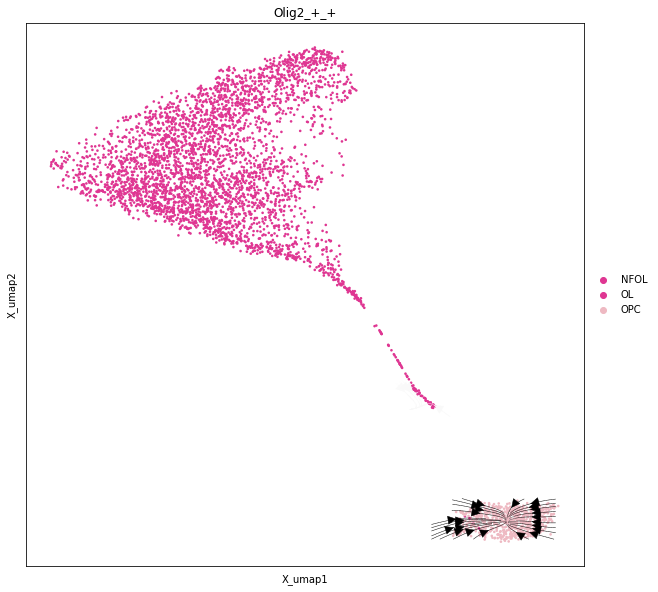

In [59]:
# Plot arrows
# os.mkdir(outDir+'/arrow_plots/')
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Olig2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save=outDir+'arrow_plots/Olig2_nothr.pdf')

We will show to additional examples below, for Sox10, Zeb2 and Tcf12:

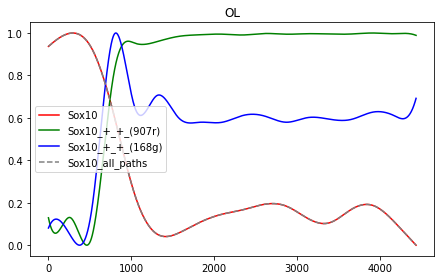

In [60]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Sox10_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig(outDir+'curve_plots/Sox10.pdf')

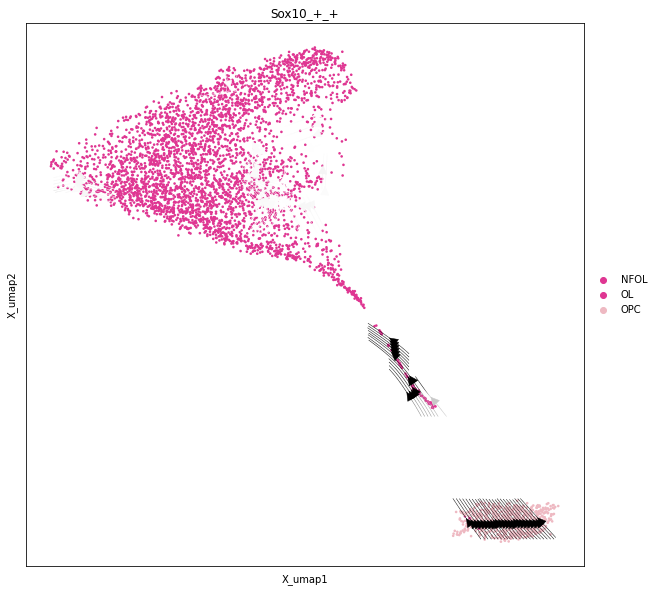

In [61]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox10_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save=outDir+'arrow_plots/Sox10_nothr.pdf')

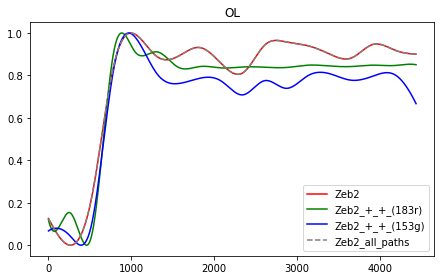

In [62]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Zeb2_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Zeb2.pdf')

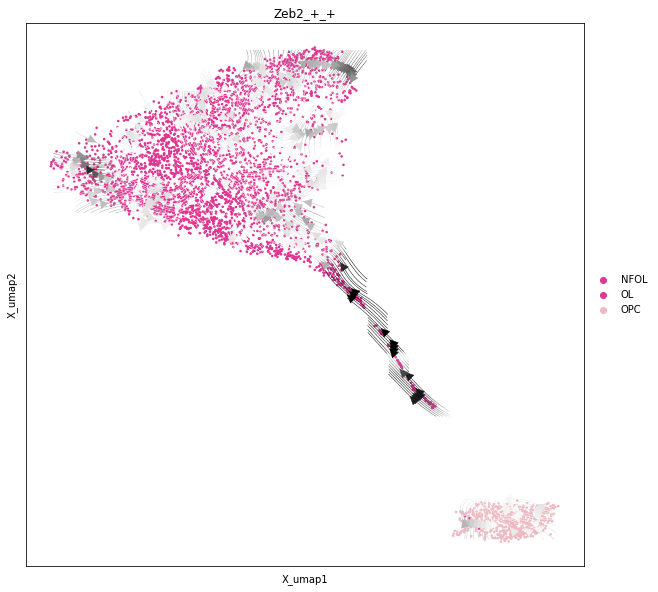

In [63]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Zeb2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Zeb2_nothr.pdf')

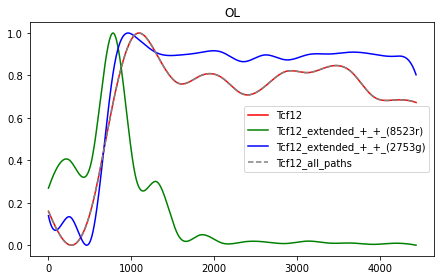

In [64]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Tcf12_extended_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Tcf12.pdf')

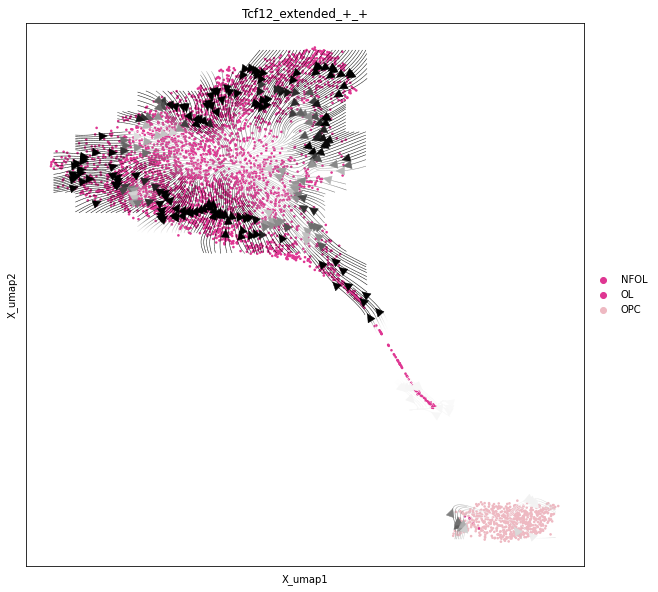

In [65]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf12_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf12_nothr.pdf')

## 3. Calculate the most relevant forces for a cell

### 3a. Calculate forces per cell

We can also prioritize differentiation forces along the trajectory. For that, we can use the `cell_forces` function, which will compute arrows for each cell and regulon, returning a matrix with the lengths of the arrows for each cell (the differentiation force).

In [13]:
# To read
import scanpy as sc
adata = sc.read_h5ad(outDir+'OL_anndata.h5ad')

In [14]:
# Set paths
paths = [('OL', ['OPC', 'NFOL', 'OL'])]

In [15]:
# Calculate path matrices
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [6]:
# We will do only for the positives as example
ke = list(paths_cascade[list(paths_cascade.keys())[0]].keys())
selected_eGRNs = [x.split('_(')[0] for x in paths_cascade['Gene'][ke[0]].columns if '+_+' in x]
len(selected_eGRNs)

400

In [ ]:
# Get differentiation forces (~10 min)
import time
df = cell_forces(adata, paths_cascade, plot_type='tf_to_gene', window=1, gam_smooth=True, tf_traj_thr=0.7, tf_expr_thr=0.2,
               selected_eGRNs=selected_eGRNs, n_cpu=20, _temp_dir='/scratch/leuven/313/vsc31305/ray_spill')

In [10]:
# Save
import dill
with open(outDir+'differenrentiation_tutorial_cell_forces.pkl', 'wb') as f:
    dill.dump(df, f)

### 3b. Get RSS

As done with the regulon AUC values, we can use the RSS function to prioritize the cell forces per cell (or group of cells). As an example, we will use the cell type labels, but you can also bin the trajectory for better resolution:

In [363]:
# Load
import dill
infile = open(outDir+'differenrentiation_tutorial_cell_forces.pkl', 'rb')
df = dill.load(infile)
infile.close()

In [368]:
# We'll filter lowly expressed TFs in this branch
import numpy as np
adata.var['Score'] = np.count_nonzero(adata.X > 1.5, axis=0)

In [369]:
# Set paths
paths = [('OL', ['OPC', 'NFOL', 'OL'])]

In [370]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [371]:
# Use only high quality regions
import pandas as pd
subset = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/HQ_regulons.tsv').iloc[:,0].tolist()
subset = [x.split('_')[0] for x in subset]
s = [x.split('_(')[0] for x in selected_features['Gene'] if '+_+' in x and x.split('_')[0] in subset and x.split('_(')[0] in df.columns and adata.var['Score'].loc[x.split('_')[0]] > 30]

In [412]:
# Get force RSS
rss_values = forces_rss(adata, df, 'Diff_state')

In [415]:
# Select oligodendrocyte relevant regulons (this is optional, but can help filter out noise)
selected_eRegulons=['Prrx1(+)', 'Meis1(+)', 'Zeb2(+)', 'Sox10(+)', 'Sox8(+)', 'Olig2(+)', 'Sox4(+)','Sox6(+)','Sox5(+)', 'Tcf4(+)', 'Bcl6_extended(+)','Tcf7l2_extended(+)', 'Tcf12_extended(+)']

In [416]:
import re
rss_values.columns = [re.sub('_\+_\+', '(+)', file) for file in rss_values.columns]
rss_values = rss_values[selected_eRegulons] # Select regulons
rss_values.columns = [re.sub('_extended', '', file) for file in rss_values.columns] # Remove extended from name to make the graph clearer
rss_values = rss_values.loc[['OPC', 'NFOL', 'OL'],:]

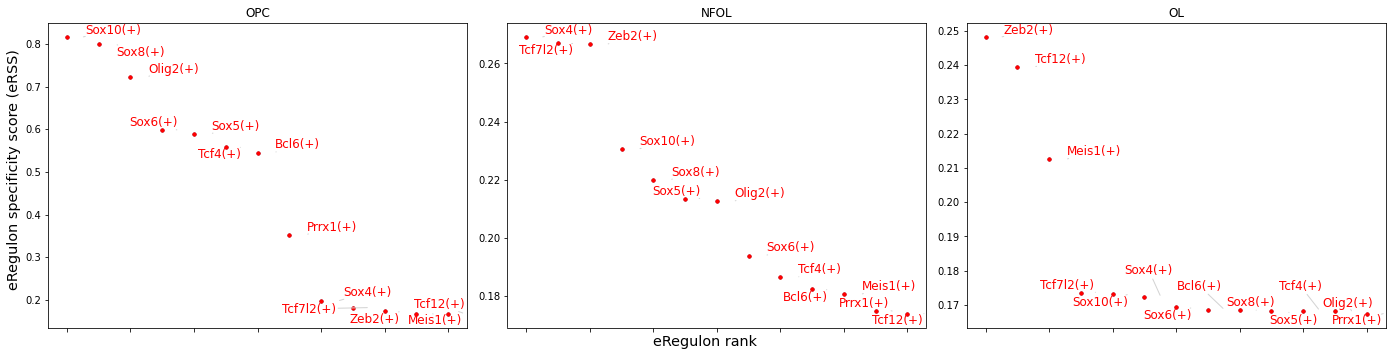

In [422]:
plot_forces_rss(rss_values, top_n=20, num_columns=3, selected_groups=['OPC', 'NFOL', 'OL'], save=outDir+'prior_rss.pdf')